In [1]:
import os
import sys
import glob
import shutil

# cuda no worky diganostics
if os.name == 'posix' and 'CONDA_PREFIX' in os.environ:
    conda_prefix = os.environ['CONDA_PREFIX']
    print(f"Conda Environment: {conda_prefix}")

    # 1. SEARCH STRATEGY
    search_patterns = [
        f"{conda_prefix}/lib/nvvm/libdevice/libdevice.10.bc",
        f"{conda_prefix}/lib/libdevice.10.bc",
        f"{conda_prefix}/nvvm/libdevice/libdevice.10.bc",
        f"{conda_prefix}/**/nvidia/cuda_nvcc/**/libdevice.10.bc",
        f"{conda_prefix}/**/libdevice.10.bc"
    ]

    found_libdevice = None
    for pattern in search_patterns:
        matches = glob.glob(pattern, recursive=True)
        if matches:
            found_libdevice = matches[0]
            print(f"✅ Found libdevice.10.bc at: {found_libdevice}")
            break

    # 2. APPLY FIXES
    if found_libdevice:
        # Fix A: Set XLA_FLAGS
        if "nvvm" in found_libdevice:
            xla_root = found_libdevice.split("/nvvm")[0]
        else:
            xla_root = os.path.dirname(os.path.dirname(found_libdevice))

        os.environ['XLA_FLAGS'] = f"--xla_gpu_cuda_data_dir={xla_root}"

        # Fix B: Symlink Hack
        local_link = "./libdevice.10.bc"
        if not os.path.exists(local_link):
            try:
                os.symlink(found_libdevice, local_link)
                print(f"🔗 Created local symlink: {local_link}")
            except Exception as e:
                print(f"⚠️ Could not create symlink: {e}")

        # Fix C: LD_LIBRARY_PATH
        lib_dir = os.path.join(conda_prefix, 'lib')
        if lib_dir not in os.environ.get('LD_LIBRARY_PATH', ''):
             os.environ['LD_LIBRARY_PATH'] = f"{lib_dir}:{os.environ.get('LD_LIBRARY_PATH', '')}"

    else:
        print("❌ CRITICAL: libdevice.10.bc NOT FOUND.")
        os.environ['TF_XLA_FLAGS'] = "--tf_xla_auto_jit=0"

print("--- END DIAGNOSTICS ---\n")

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ Enabled Memory Growth for {len(gpus)} GPU(s).")
    except RuntimeError as e:
        print(f"⚠️ GPU Config Error: {e}")

# Hyprparams
IMG_SIZE = 128
CHANNELS = 1
NUM_CLASSES = 6
LATENT_DIM = 128

# keep batch size low my gpu cant handle more!
BATCH_SIZE = 16

EPOCHS = 100
CRITIC_EXTRA_STEPS = 5
GP_WEIGHT = 10.0

# Paths
DATASET_DIR = "Research_Radar_Dataset/raw_matrix"
OUTPUT_DIR = "training_progress"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"TensorFlow Version: {tf.__version__}")
if len(gpus) > 0:
    print(f"GPU Details: {gpus}")
else:
    print("WARNING: No GPU detected.")

--- STARTING CUDA DIAGNOSTICS ---
Conda Environment: /home/underroot/miniconda3
✅ Found libdevice.10.bc at: /home/underroot/miniconda3/lib/python3.12/site-packages/triton/backends/nvidia/lib/libdevice.10.bc
--- END DIAGNOSTICS ---



2025-12-20 00:13:22.975989: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-20 00:13:22.986692: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766169803.000076 2241253 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766169803.004155 2241253 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-20 00:13:23.018075: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

✅ Enabled Memory Growth for 1 GPU(s).
TensorFlow Version: 2.18.0
GPU Details: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
def load_radar_dataset(data_dir):
    file_paths = glob.glob(os.path.join(data_dir, "*.mat"))

    if len(file_paths) == 0:
        raise ValueError(f"No .mat files found in {data_dir}. Run the MATLAB script first!")

    print(f"Found {len(file_paths)} samples. Loading into memory...")

    images = []
    labels = []

    for f in file_paths:
        try:
            mat = scipy.io.loadmat(f)
            img = mat['gan_matrix']
            lbl = int(mat['classID'][0][0]) - 1

            images.append(img)
            labels.append(lbl)
        except Exception as e:
            print(f"Error reading {f}: {e}")

    X = np.array(images, dtype=np.float32)
    y = np.array(labels, dtype=np.int32)

    # Reshape for TensorFlow: (N, 128, 128, 1)
    X = np.expand_dims(X, axis=-1)
    y = np.expand_dims(y, axis=-1)

    print(f"Dataset Loaded. Shape: {X.shape}")
    print(f"Value Range: [{np.min(X):.2f}, {np.max(X):.2f}] (Should be approx -1 to 1)")

    return X, y

train_images, train_labels = load_radar_dataset(DATASET_DIR)

dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

Found 3000 samples. Loading into memory...
Dataset Loaded. Shape: (3000, 128, 128, 1)
Value Range: [-1.00, 1.00] (Should be approx -1 to 1)


I0000 00:00:1766169810.229512 2241253 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1991 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_generator(latent_dim, num_classes, img_size):
    z_input = layers.Input(shape=(latent_dim,))
    label_input = layers.Input(shape=(1,), dtype='int32')

    label_embedding = layers.Embedding(num_classes, latent_dim)(label_input)
    label_embedding = layers.Flatten()(label_embedding)

    joined = layers.Concatenate()([z_input, label_embedding])

    # Foundation: 4x4 image
    start_dim = img_size // 32 # 128 / 32 = 4
    x = layers.Dense(start_dim * start_dim * 512)(joined)
    x = layers.Reshape((start_dim, start_dim, 512))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)

    # Block 1: 4 -> 8
    x = layers.UpSampling2D(size=(2, 2), interpolation='nearest')(x)
    x = layers.Conv2D(512, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)

    # Block 2: 8 -> 16
    x = layers.UpSampling2D(size=(2, 2), interpolation='nearest')(x)
    x = layers.Conv2D(256, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)

    # Block 3: 16 -> 32
    x = layers.UpSampling2D(size=(2, 2), interpolation='nearest')(x)
    x = layers.Conv2D(128, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)

    # Block 4: 32 -> 64
    x = layers.UpSampling2D(size=(2, 2), interpolation='nearest')(x)
    x = layers.Conv2D(64, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)

    # Block 5: 64 -> 128
    x = layers.UpSampling2D(size=(2, 2), interpolation='nearest')(x)
    x = layers.Conv2D(1, (3,3), padding='same')(x)

    out_img = layers.Activation('tanh')(x)

    return models.Model([z_input, label_input], out_img, name="generator")

def build_critic(img_size, num_classes):

    img_input = layers.Input(shape=(img_size, img_size, 1))
    label_input = layers.Input(shape=(1,), dtype='int32')


    # Block 1: 128 -> 64
    x = layers.Conv2D(64, (4,4), strides=(2,2), padding='same')(img_input)
    x = layers.LeakyReLU(negative_slope=0.2)(x)

    # Block 2: 64 -> 32
    x = layers.Conv2D(128, (4,4), strides=(2,2), padding='same')(x)
    x = layers.LayerNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)

    # Block 3: 32 -> 16
    x = layers.Conv2D(256, (4,4), strides=(2,2), padding='same')(x)
    x = layers.LayerNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)

    # Block 4: 16 -> 8
    x = layers.Conv2D(512, (4,4), strides=(2,2), padding='same')(x)
    x = layers.LayerNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)

    # Block 5: 8 -> 4 (New! Deeper to capture global Doppler physics)
    x = layers.Conv2D(512, (4,4), strides=(2,2), padding='same')(x)
    x = layers.LayerNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)

    x = layers.Flatten()(x)

    features = layers.Dense(512)(x)
    features = layers.LeakyReLU(negative_slope=0.2)(features)

    # D(x, y) = f(x) + <phi(x), E(y)>

    validity = layers.Dense(1)(features)

    label_embedding = layers.Embedding(num_classes, 512)(label_input)
    label_embedding = layers.Flatten()(label_embedding)

    projection = layers.Dot(axes=1)([features, label_embedding])

    out_score = layers.Add()([validity, projection])

    return models.Model([img_input, label_input], out_score, name="projection_critic")

d_model = build_critic(IMG_SIZE, NUM_CLASSES)
g_model = build_generator(LATENT_DIM, NUM_CLASSES, IMG_SIZE)

print("Architecture Upgrade Complete.")
print("- Generator: 5-Stage Upsampling (Matches Critic Depth)")
print("- Critic: 5-Stage Downsampling + Projection Discriminator")
print("- Compilation: optimized for XLA (Flatten vs GlobalPool)")
d_model.summary()

W0000 00:00:1766169817.174232 2243444 gpu_backend_lib.cc:579] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  /home/underroot/miniconda3/lib/python3.12/site-packages/triton/backends/nvidia
  ipykernel_launcher.runfiles/cuda_nvcc
  ipykern/cuda_nvcc
  
  /usr/local/cuda
  /home/underroot/miniconda3/lib/python3.12/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc
  /home/underroot/miniconda3/lib/python3.12/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc
  /home/underroot/miniconda3/lib/python3.12/site-packages/tensorflow/python/platform/../../cuda
  .
You can choose the search directory by setting xla_gpu_cuda_data_dir in HloModule's DebugOptions.  For most apps, setting the environment variable XLA_FLAGS=--xla_gpu_cuda_data_dir=/path/to/cuda will work.


Architecture Upgrade Complete.
- Generator: 5-Stage Upsampling (Matches Critic Depth)
- Critic: 5-Stage Downsampling + Projection Discriminator
- Compilation: optimized for XLA (Flatten vs GlobalPool)


Model: "projection_critic"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      1,088 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 64, 64,    │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │    131,200 │ leaky_re_lu[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 32, 32,    │        256 │ conv2d_1[0][0]    │
│ (LayerNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 32, 32,    │          0 │ layer_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │    524,544 │ leaky_re_lu_1[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_2[0][0]    │
│ (LayerNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 16, 16,    │          0 │ layer_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 512) │  2,097,664 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 8, 8, 512) │      1,024 │ conv2d_3[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 8, 8, 512) │          0 │ layer_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 4, 4, 512) │  4,194,816 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 4, 4, 512) │      1,024 │ conv2d_4[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 4, 4, 512) │          0 │ layer_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 8192)      │          0 │ leaky_re_lu_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  4,194,816 │ flatten[0][0]   

 Total params: 11,150,529 (42.54 MB)

 Trainable params: 11,150,529 (42.54 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
class ConditionalWGANGP(models.Model):
    def __init__(self, generator, discriminator, latent_dim, critic_steps=5, gp_weight=10.0):
        super(ConditionalWGANGP, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer):
        super(ConditionalWGANGP, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        # WGAN Loss: D(fake) - D(real)
        self.d_loss_fn = lambda real, fake: tf.reduce_mean(fake) - tf.reduce_mean(real)
        self.g_loss_fn = lambda fake: -tf.reduce_mean(fake)

    def gradient_penalty(self, batch_size, real_images, fake_images, labels):
        alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.discriminator([interpolated, labels], training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]

        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))

        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, data):
        real_images, labels = data
        batch_size = tf.shape(real_images)[0]

        for i in range(self.critic_steps):

            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

            with tf.GradientTape() as tape:
                fake_images = self.generator([random_latent_vectors, labels], training=True)

                fake_logits = self.discriminator([fake_images, labels], training=True)
                real_logits = self.discriminator([real_images, labels], training=True)

                d_cost = self.d_loss_fn(real=real_logits, fake=fake_logits)
                gp = self.gradient_penalty(batch_size, real_images, fake_images, labels)
                d_loss = d_cost + (self.gp_weight * gp)

            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        with tf.GradientTape() as tape:
            generated_images = self.generator([random_latent_vectors, labels], training=True)
            gen_img_logits = self.discriminator([generated_images, labels], training=True)
            g_loss = self.g_loss_fn(gen_img_logits)

        g_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_gradient, self.generator.trainable_variables))

        return {"d_loss": d_loss, "g_loss": g_loss}

In [5]:
class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, num_img=6, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        # Fixed noise and labels to see evolution of specific examples
        self.random_latent_vectors = tf.random.normal(shape=(num_img, latent_dim))
        self.labels = tf.convert_to_tensor(np.arange(num_img).reshape(-1, 1), dtype=tf.int32)

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0:
            generated_images = self.model.generator([self.random_latent_vectors, self.labels])
            generated_images = (generated_images * 0.5) + 0.5 # Rescale [-1,1] to [0,1] for plot

            fig = plt.figure(figsize=(12, 4))
            titles = ["F-16 (Jet)", "F-15 (Jet)", "Su-57 (Jet)", "C-130 (Prop)", "MQ-9 (Prop)", "Drone (Fast Rotor)"]

            for i in range(self.num_img):
                if i >= len(titles): break
                plt.subplot(1, self.num_img, i+1)
                plt.imshow(generated_images[i, :, :, 0], cmap='jet') # Use JET to look like radar
                plt.title(titles[i])
                plt.axis("off")

            plt.savefig(f"{OUTPUT_DIR}/epoch_{epoch:03d}.png")
            plt.close()

generator_optimizer = optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
discriminator_optimizer = optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)

wgan = ConditionalWGANGP(
    generator=g_model,
    discriminator=d_model,
    latent_dim=LATENT_DIM,
    critic_steps=CRITIC_EXTRA_STEPS,
    gp_weight=GP_WEIGHT
)

wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer
)

print("Starting Training...")
history = wgan.fit(
    dataset,
    epochs=EPOCHS,
    callbacks=[GANMonitor(num_img=NUM_CLASSES, latent_dim=LATENT_DIM)]
)

print("Training Complete.")

Starting Training...
Epoch 1/100


I0000 00:00:1766169844.636271 2242558 service.cc:148] XLA service 0x7f909c025160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766169844.636286 2242558 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-12-20 00:14:05.572137: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-20 00:14:06.361749: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:61] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform/RandomUniform
I0000 00:00:1766169847.767730 2242558 cuda_dnn.cc:529] Loaded cuDNN version 90501
I0000 00:00:1766169875.441909 2242558 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pr

187/187 ━━━━━━━━━━━━━━━━━━━━ 131s 441ms/step - d_loss: -50.0040 - g_loss: -83.4574
Epoch 2/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 81s 432ms/step - d_loss: -32.2701 - g_loss: -171.4594
Epoch 3/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 81s 434ms/step - d_loss: -24.4648 - g_loss: -36.9944
Epoch 4/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 81s 435ms/step - d_loss: -21.4906 - g_loss: 48.8704
Epoch 5/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 81s 436ms/step - d_loss: -19.3755 - g_loss: 54.4658
Epoch 6/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 82s 437ms/step - d_loss: -17.5410 - g_loss: 46.9113
Epoch 7/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 82s 437ms/step - d_loss: -14.8061 - g_loss: 35.4024
Epoch 8/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 82s 438ms/step - d_loss: -12.4303 - g_loss: 48.7072
Epoch 9/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 82s 438ms/step - d_loss: -10.1929 - g_loss: 54.2932
Epoch 10/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 82s 439ms/step - d_loss: -8.0826 - g_loss: 48.9155
Epoch 11/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 82s 440ms/step - d_loss: -8.3776 - 

Generating C-130 Propeller Signatures...


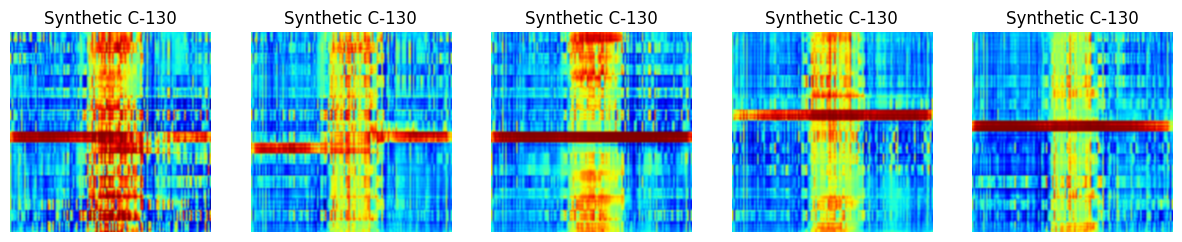

Generating F-16 Jet Signatures...


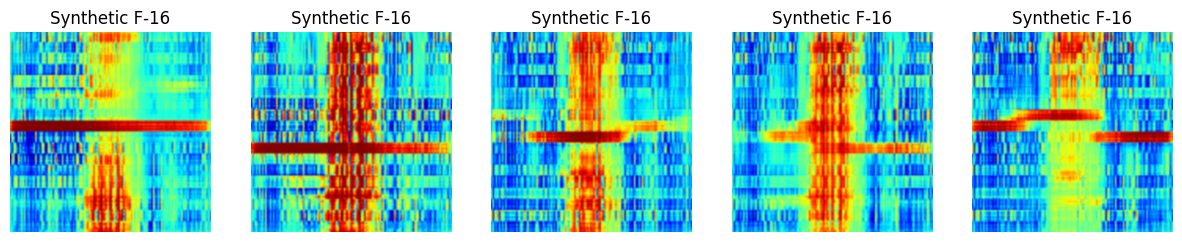

In [6]:
def generate_synthetic_data(class_idx, count=1):
    class_names = ["F-16", "F-15", "Su-57", "C-130", "MQ-9", "Drone"]

    noise = tf.random.normal(shape=(count, LATENT_DIM))
    labels = tf.fill((count, 1), class_idx)

    imgs = wgan.generator([noise, labels], training=False)

    plt.figure(figsize=(15, 3))
    for i in range(count):
        plt.subplot(1, count, i+1)
        # Convert back to dB-like scale for visualization
        img_disp = (imgs[i, :, :, 0] * 0.5) + 0.5
        plt.imshow(img_disp, cmap='jet', interpolation='bicubic')
        plt.title(f"Synthetic {class_names[class_idx]}")
        plt.axis('off')
    plt.show()

print("Generating C-130 Propeller Signatures...")
generate_synthetic_data(class_idx=3, count=5)

print("Generating F-16 Jet Signatures...")
generate_synthetic_data(class_idx=0, count=5)

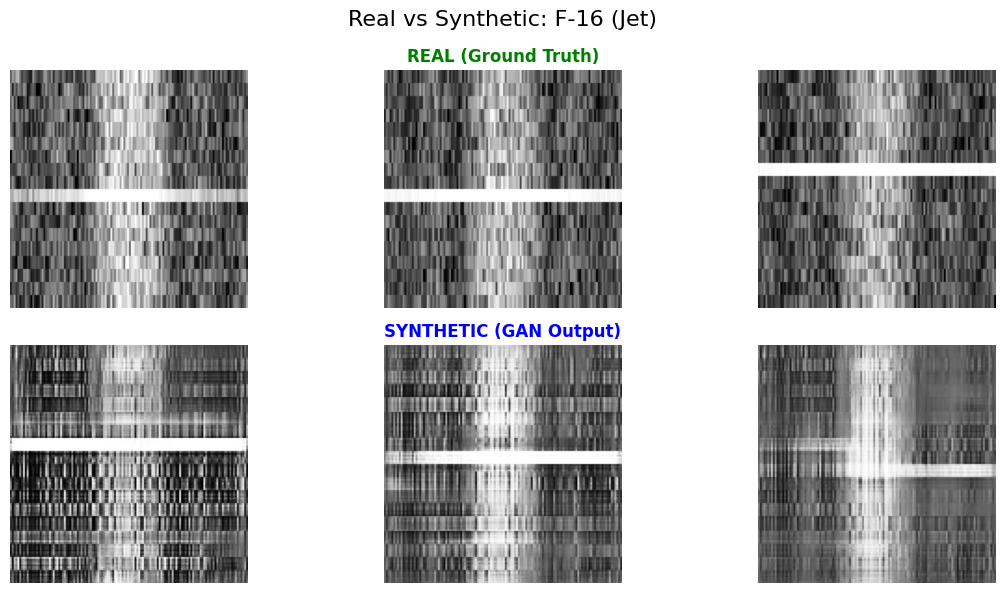

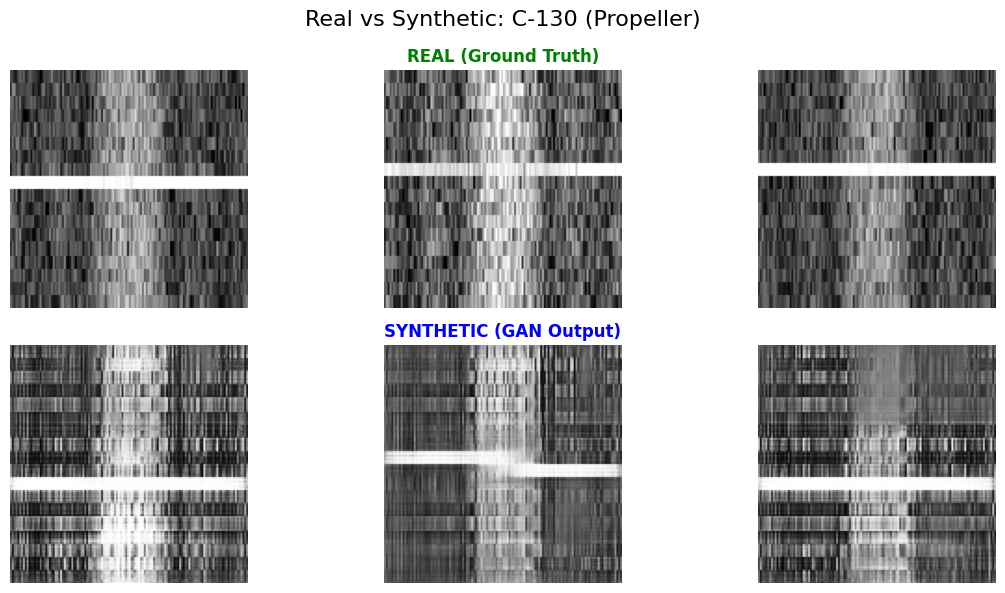

2025-12-20 03:15:15.110478: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.16GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


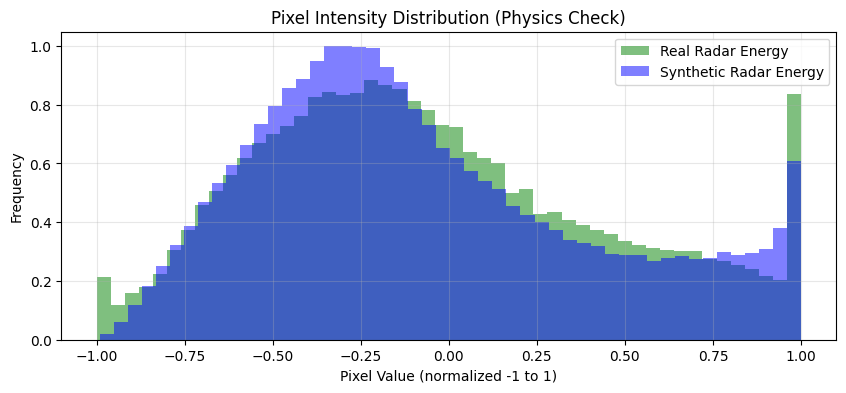

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import os
import glob

IMG_SIZE = 128
LATENT_DIM = 128
NUM_CLASSES = 6
DATASET_DIR = "Research_Radar_Dataset/raw_matrix"
CLASS_NAMES = ["F-16 (Jet)", "F-15 (Jet)", "Su-57 (Jet)", "C-130 (Prop)", "MQ-9 (Prop)", "Drone (Rotor)"]

def get_real_samples(class_idx, count=1):
    all_files = glob.glob(os.path.join(DATASET_DIR, "*.mat"))
    found_imgs = []

    for f in all_files:
        if len(found_imgs) >= count: break
        try:
            mat = scipy.io.loadmat(f)
            lbl = int(mat['classID'][0][0]) - 1
            if lbl == class_idx:
                img = mat['gan_matrix'] # This is [-1, 1]
                found_imgs.append(img)
        except:
            continue

    if len(found_imgs) < count:
        print(f"Warning: Not enough real samples found for class {class_idx}")
        while len(found_imgs) < count:
            found_imgs.append(np.zeros((IMG_SIZE, IMG_SIZE)))

    return np.array(found_imgs)


def compare_real_vs_fake(class_idx, class_name):
    real_imgs = get_real_samples(class_idx, count=3)

    noise = tf.random.normal(shape=(3, LATENT_DIM))
    labels = tf.fill((3, 1), class_idx)
    fake_imgs = wgan.generator([noise, labels], training=False).numpy()

    plt.figure(figsize=(12, 6))
    plt.suptitle(f"Real vs Synthetic: {class_name}", fontsize=16)

    for i in range(3):
        plt.subplot(2, 3, i+1)
        img = (real_imgs[i] * 0.5) + 0.5
        plt.imshow(img, cmap='gray', vmin=0, vmax=1)
        if i == 1: plt.title("REAL (Ground Truth)", fontweight='bold', color='green')
        plt.axis('off')

    for i in range(3):
        plt.subplot(2, 3, i+4)
        img = (fake_imgs[i, :, :, 0] * 0.5) + 0.5
        plt.imshow(img, cmap='gray', vmin=0, vmax=1)
        if i == 1: plt.title("SYNTHETIC (GAN Output)", fontweight='bold', color='blue')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def plot_pixel_distribution():

    real_batch, _ = next(iter(dataset.take(1)))
    real_batch = real_batch.numpy()

    noise = tf.random.normal(shape=(BATCH_SIZE, LATENT_DIM))
    labels = tf.random.uniform((BATCH_SIZE, 1), minval=0, maxval=NUM_CLASSES, dtype=tf.int32)
    fake_batch = wgan.generator([noise, labels], training=False).numpy()

    plt.figure(figsize=(10, 4))
    plt.hist(real_batch.flatten(), bins=50, alpha=0.5, label='Real Radar Energy', color='green', density=True)
    plt.hist(fake_batch.flatten(), bins=50, alpha=0.5, label='Synthetic Radar Energy', color='blue', density=True)
    plt.title("Pixel Intensity Distribution (Physics Check)")
    plt.xlabel("Pixel Value (normalized -1 to 1)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


compare_real_vs_fake(0, "F-16 (Jet)")

compare_real_vs_fake(3, "C-130 (Propeller)")

plot_pixel_distribution()